In [1]:
import jax

jax.devices()

[gpu(id=0)]

In [ ]:
import ott

In [ ]:
import equinox

In [3]:
import os
os.system("nvidia-smi")

Wed Aug  2 09:49:57 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM3-32GB            Off| 00000000:28:00.0 Off |                    0 |
| N/A   29C    P0               65W / 350W|  24689MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

0

In [2]:
import jax.numpy as jnp
a = jnp.zeros((1,1))

2023-08-02 09:48:10.169163: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:413] There was an error before creating cudnn handle (302): cudaGetErrorName symbol not found. : cudaGetErrorString symbol not found.


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [4]:
import seaborn as sns
import jax
import ott
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from entot.data.data import MixtureNormalSampler
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, Bridge_MLP_mean
from entot.plotting.plots import plot_1D_balanced

AttributeError: module 'equinox.internal' has no attribute 'AbstractClassVar'

In [ ]:
source = MixtureNormalSampler(jax.random.PRNGKey(0), [0], 1,  0.5, batch_size=1024)
target = MixtureNormalSampler(jax.random.PRNGKey(1), [-1.0,1.0], 1,  0.1, batch_size=1024)

In [ ]:
neural_net = MLP_vector_field(1, 128, 128, 128, n_frequencies=10)
bridge_net = Bridge_MLP_mean(1, 128, 128)
ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn()
solver_latent_to_data = ott.solvers.linear.sinkhorn.Sinkhorn()

otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, epsilon=1e-1, input_dim=1, output_dim=1, iterations=20_000, k_noise_per_x=10, solver_latent_to_data=solver_latent_to_data)

In [ ]:
otfm(source, target, 1024, 1024)

In [7]:
source.batch_size = 1024
source_batch = next(source)
res, _ , _= otfm.transport(source_batch, seed=0)

<Axes: ylabel='Density'>

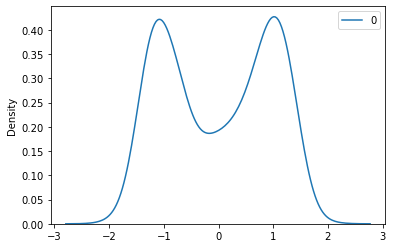

In [8]:
sns.kdeplot(res[0,...])

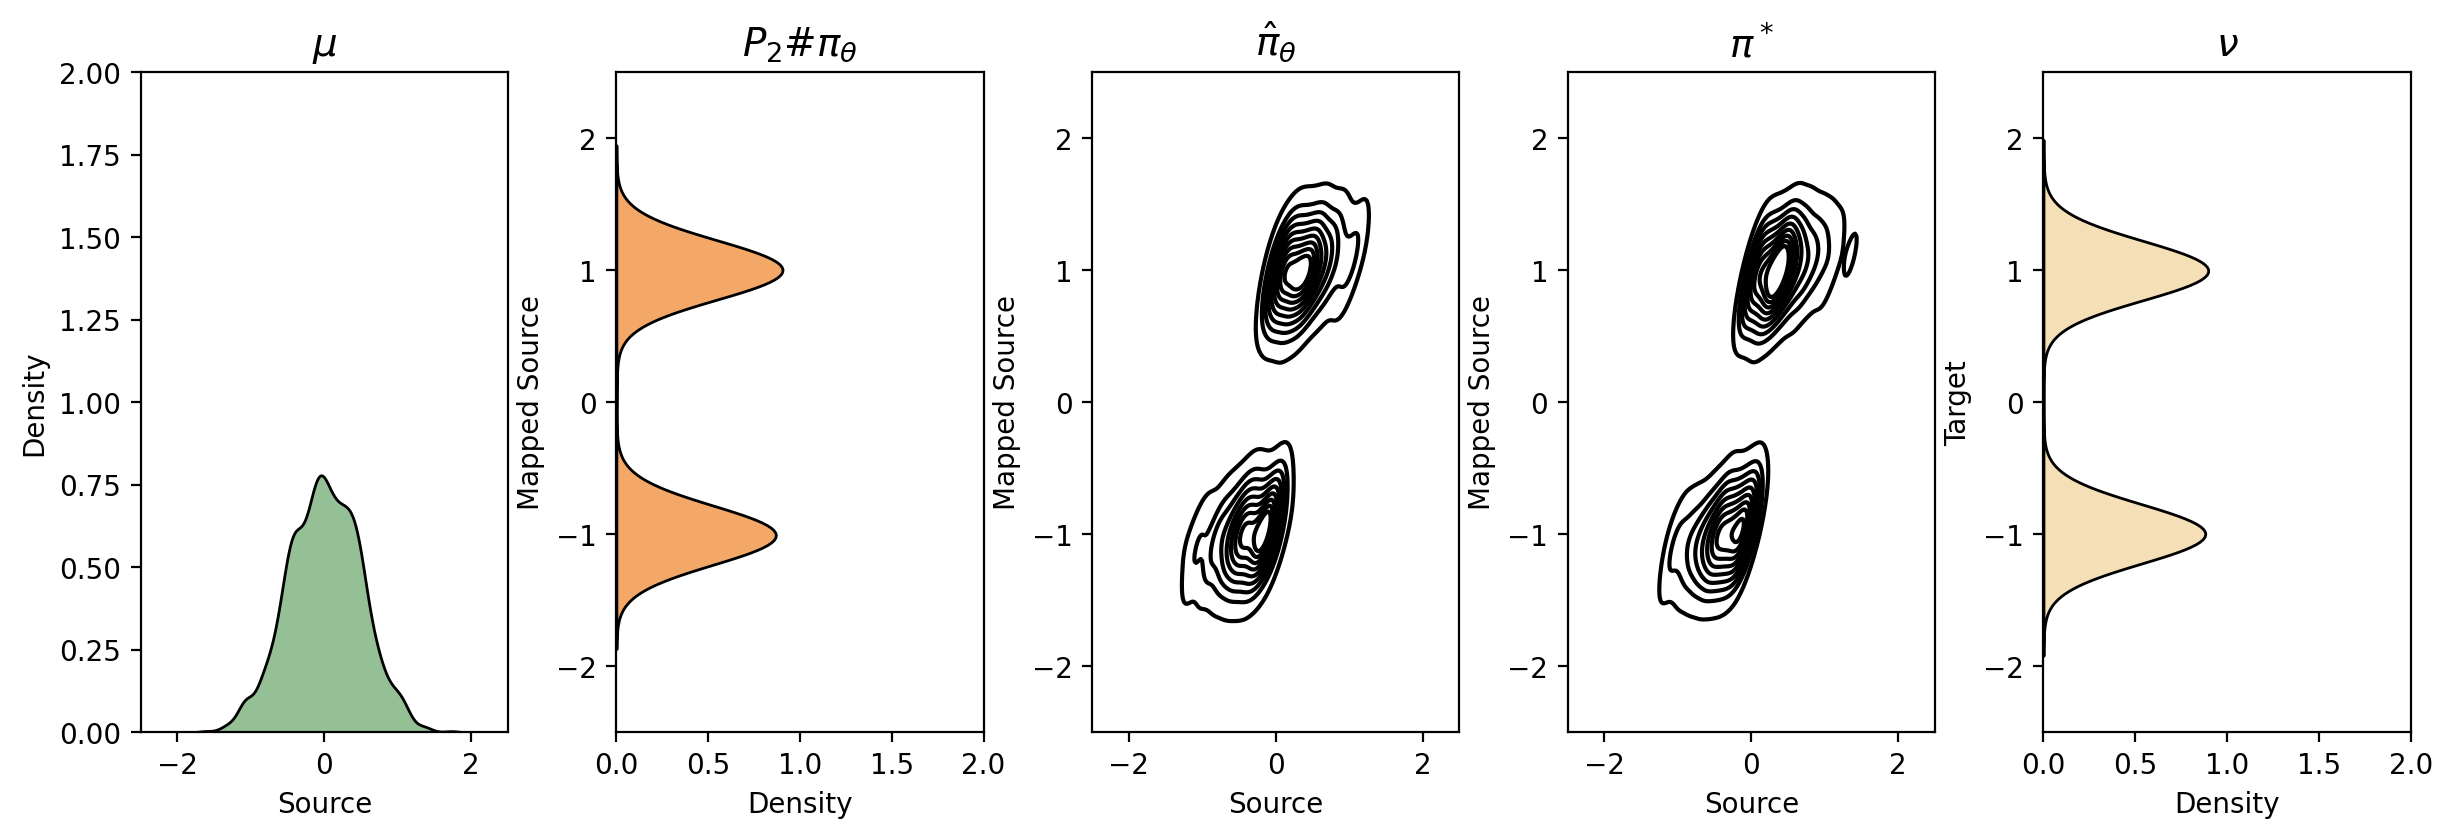

In [12]:
kwargs = {}
a = (-2.5, 2.5)
b = (0.0, 2.0)

kwargs["00_xlim"] = a
kwargs["01_xlim"] = b
kwargs["02_xlim"] = a
kwargs["10_xlim"] = a
kwargs["11_xlim"] = b
kwargs["12_xlim"] = b

kwargs["00_ylim"] = b
kwargs["01_ylim"] = a
kwargs["02_ylim"] = a
kwargs["10_ylim"] = a
kwargs["11_ylim"] = a
kwargs["12_ylim"] = a

kwargs["bw_adjust"] = 0.8

source.batch_size = 1024
source_batch = next(source)

target.batch_size = 1024
target_batch = next(target)

res, _, _ = otfm.transport(source_batch, seed=0, diffeqsolve_kwargs={"max_steps": 1_000_000})

_  = plot_1D_balanced(source_batch, target_batch, res[0,...], 1e-1, **kwargs)

## Plotting the vector fields

In [21]:
source_repeat = jnp.ones((1,)) * 0.0
source_repeat = jnp.repeat(source_repeat, 200)[:, None]

ts = np.linspace(0,1,20)
saveat=diffrax.SaveAt(ts=ts)

res, sol, _ = otfm.transport(source_repeat, seed=0, diffeqsolve_kwargs={"saveat": saveat})

tracks = sol.ys[...,0]

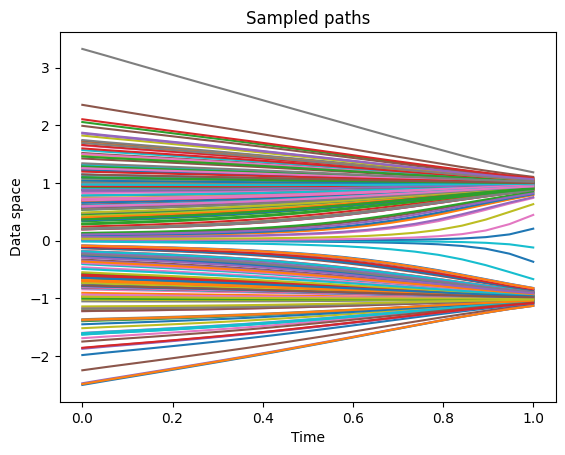

In [22]:
plt.plot(ts, tracks)
plt.xlabel("Time")
plt.ylabel("Data space")
plt.title("Sampled paths")
plt.show()

In [23]:
source_repeat = jnp.ones((1,)) * 0.0
source_repeat = jnp.repeat(source_repeat, 20)[:, None]

ts = np.linspace(0,1,20)
saveat=diffrax.SaveAt(ts=ts)

res, sol, _ = otfm.transport(source_repeat, seed=0, diffeqsolve_kwargs={"saveat": saveat})

tracks = sol.ys[...,0]

t_vec = ts[1:] - ts[:-1]
t_vector = np.tile(t_vec[:, None], (1, tracks.shape[-1]))
y_vector = tracks[1:, ...] - tracks[:-1,...]
t_augmented = np.tile(ts[:, None], (1, tracks.shape[-1]))[:-1, ...]

Text(0, 0.5, 'Target space')

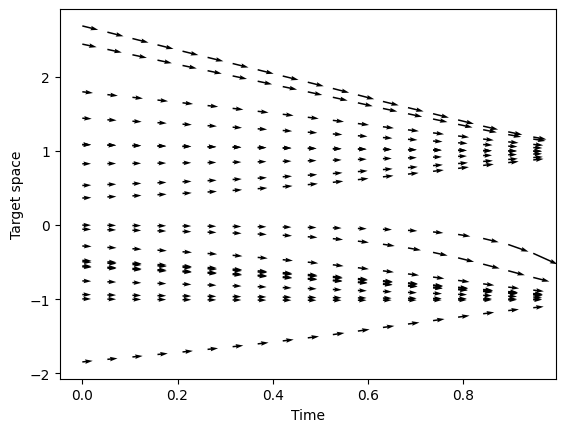

In [24]:
plt.quiver(t_augmented, tracks[:-1], t_vector, y_vector, angles="xy", scale=3)#,  headwidth=5, headlength=2, headaxislength=5)
plt.xlabel("Time")
plt.ylabel("Target space")